In [1]:
# Standard Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sns 


# For Network
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.layers import Flatten, Dense, Dropout
from keras import Model, optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

In [2]:
BATCH_SIZE = 32
EPOCHS = 20

TRAIN_PATH = '/content/drive/MyDrive/Pneumonia/inceptionv3/dataset/chest_xray/train'
TEST_PATH = '/content/drive/MyDrive/Pneumonia/inceptionv3/dataset/chest_xray/test'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

In [3]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1341
Pneumonia images in train-set:  3875
Total images in train-set:  5216 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5840


In [4]:
# Data-Augmentation Parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0. 
                                   samplewise_std_normalization=True) # Divide each input by its std.
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


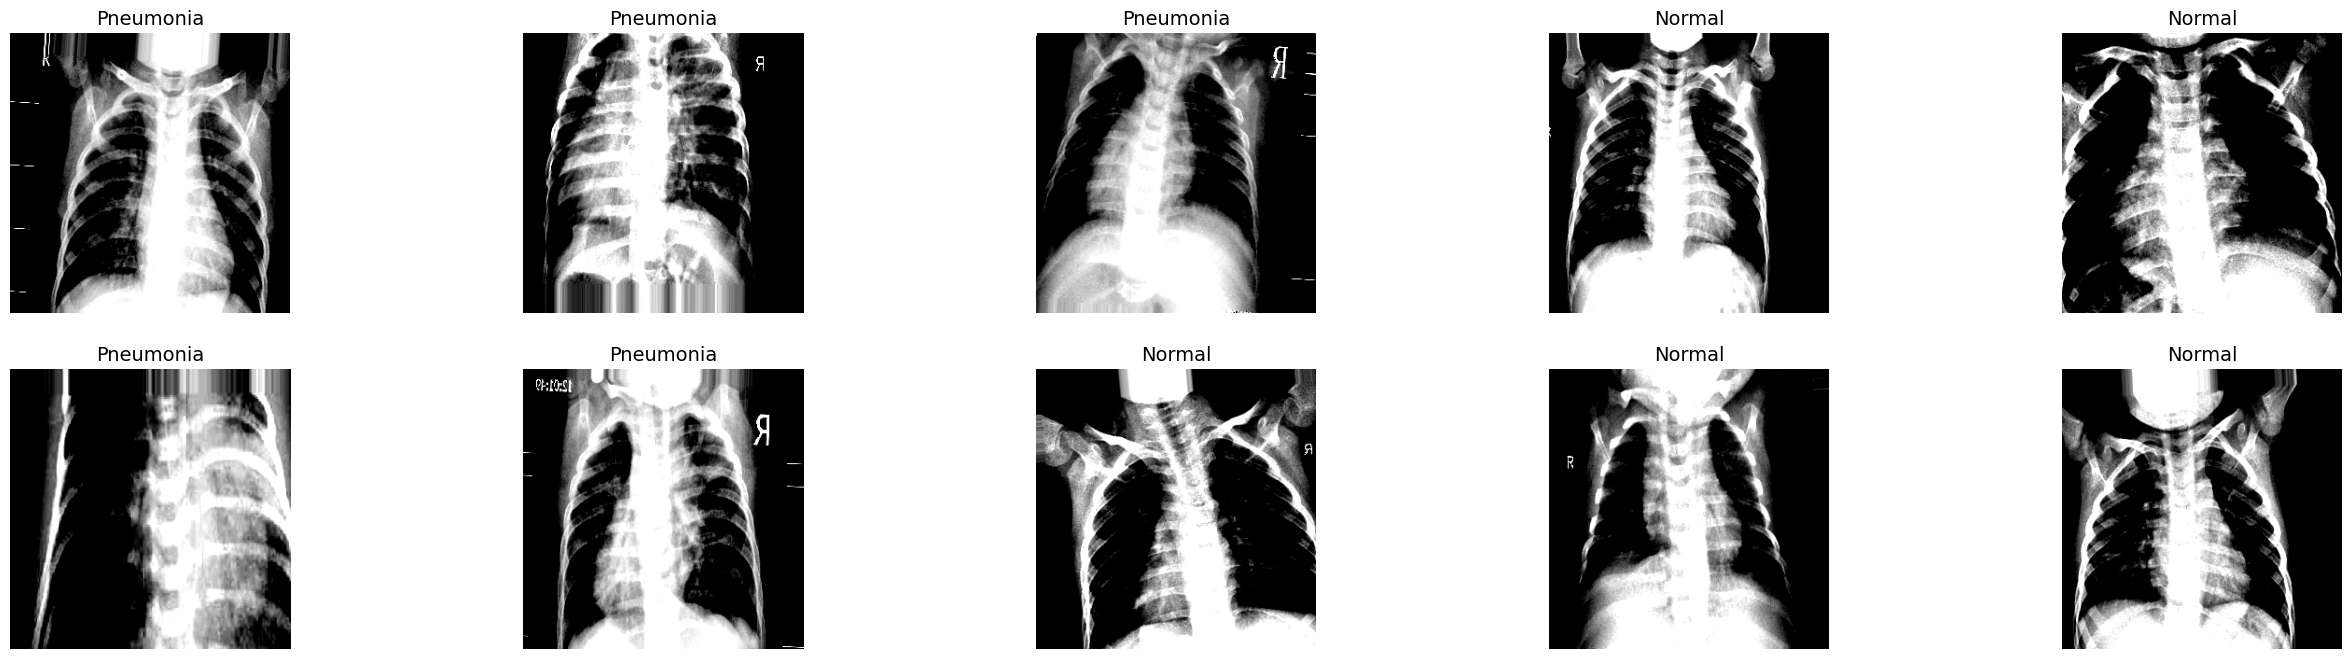

In [5]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

In [6]:
# InceptionV3 with Transfer Learning
def craete_model():
    
    # Load v3 model without the top layer
    inception_v3_model = InceptionV3(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)

    # Freeze
    inception_v3_model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(inception_v3_model.layers[-1].output) # Flatt last v3 layer (except the last).
    fc1 = Dense(units=128, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=inception_v3_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [7]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [9]:
# For TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='/content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1),

                TensorBoard(log_dir=log_dir, histogram_freq=1) ]

In [10]:
# If x is a dataset -> y should not be specified (since targets will be obtained from x).
history = model.fit(train_generator,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('/content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5')

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9099 
Epoch 1: val_accuracy improved from -inf to 0.93576, saving model to /content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5
131/131 [==============================] - 1684s 13s/step - loss: 0.2223 - accuracy: 0.9099 - val_loss: 0.1576 - val_accuracy: 0.9358
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9456
Epoch 2: val_accuracy improved from 0.93576 to 0.95398, saving model to /content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5
131/131 [==============================] - 209s 2s/step - loss: 0.1438 - accuracy: 0.9456 - val_loss: 0.1196 - val_accuracy: 0.9540
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9533
Epoch 3: val_accuracy improved from 0.95398 to 0.95973, saving model to /content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5
131/131 [==============================] - 201s 2s/step - los

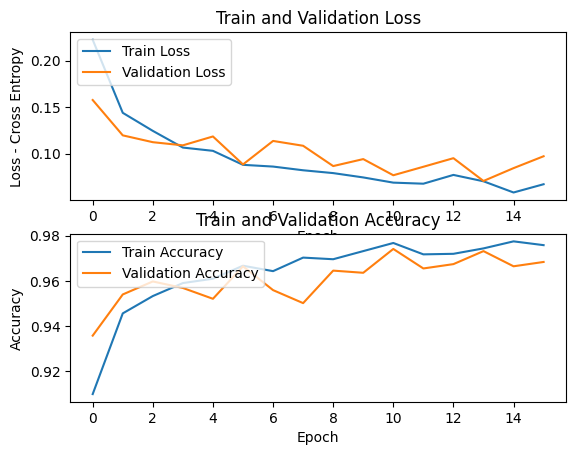

In [11]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  0.489435
Test Accuracy:  81.25 %


1/1 [==============================] - 3s 3s/step


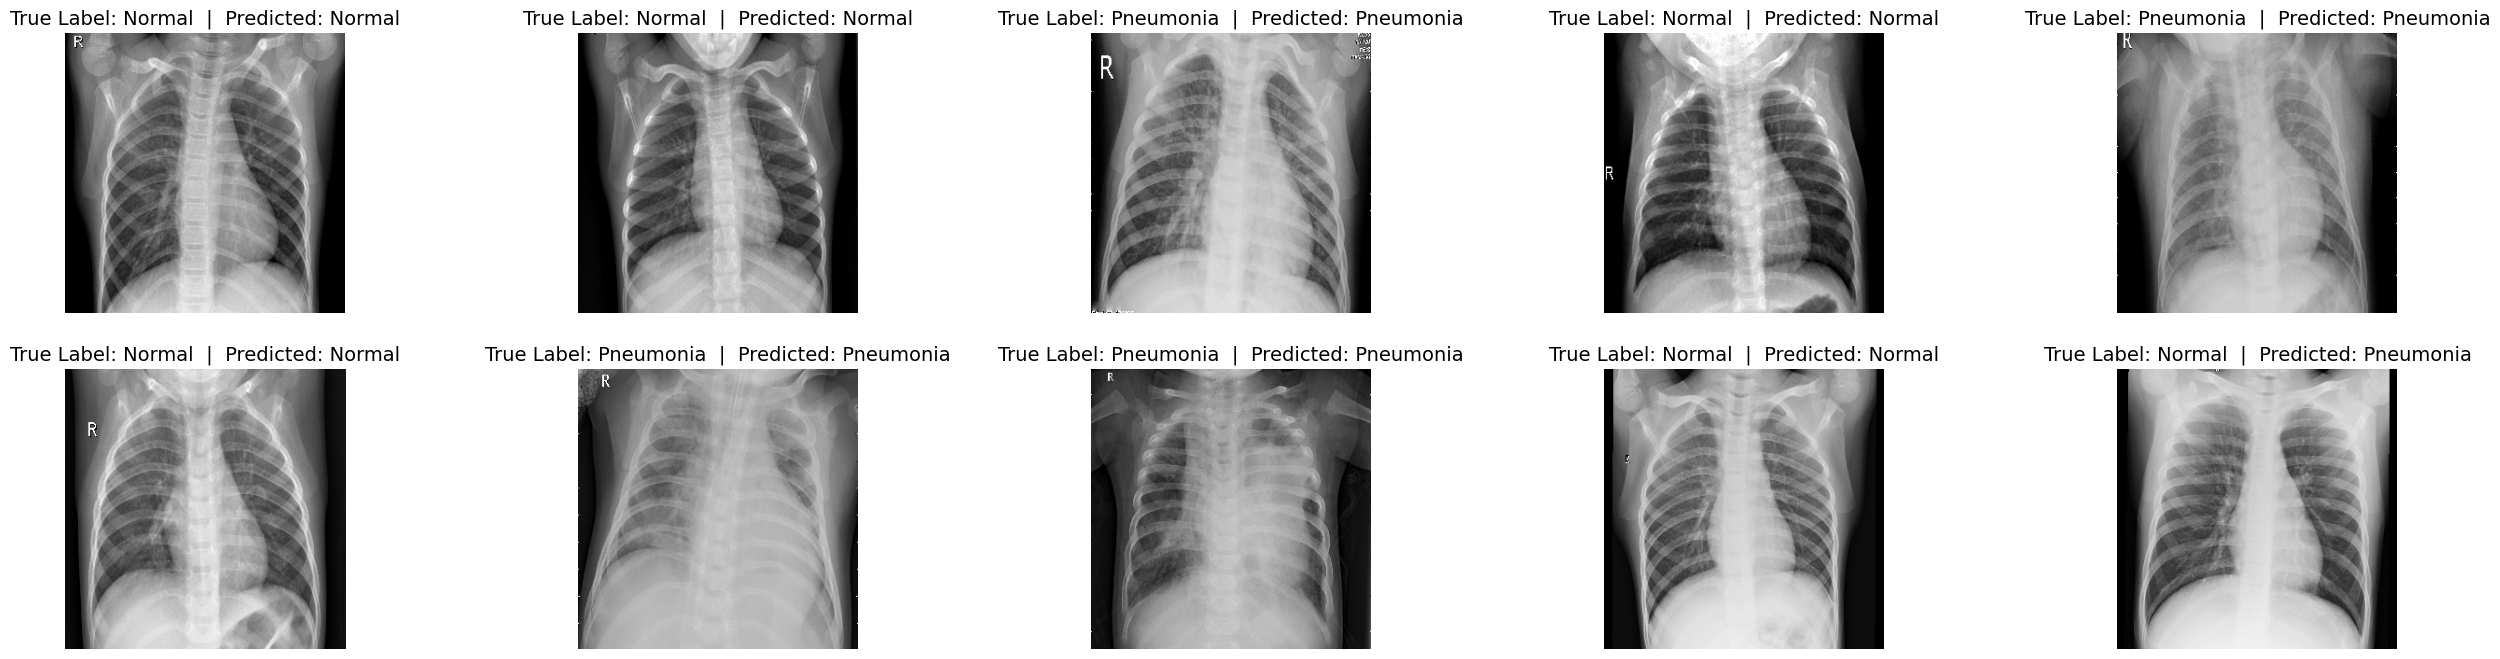

In [13]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

20/20 [==============================] - 10s 385ms/step


Text(0.5, 1.0, 'Confusion Matrix')

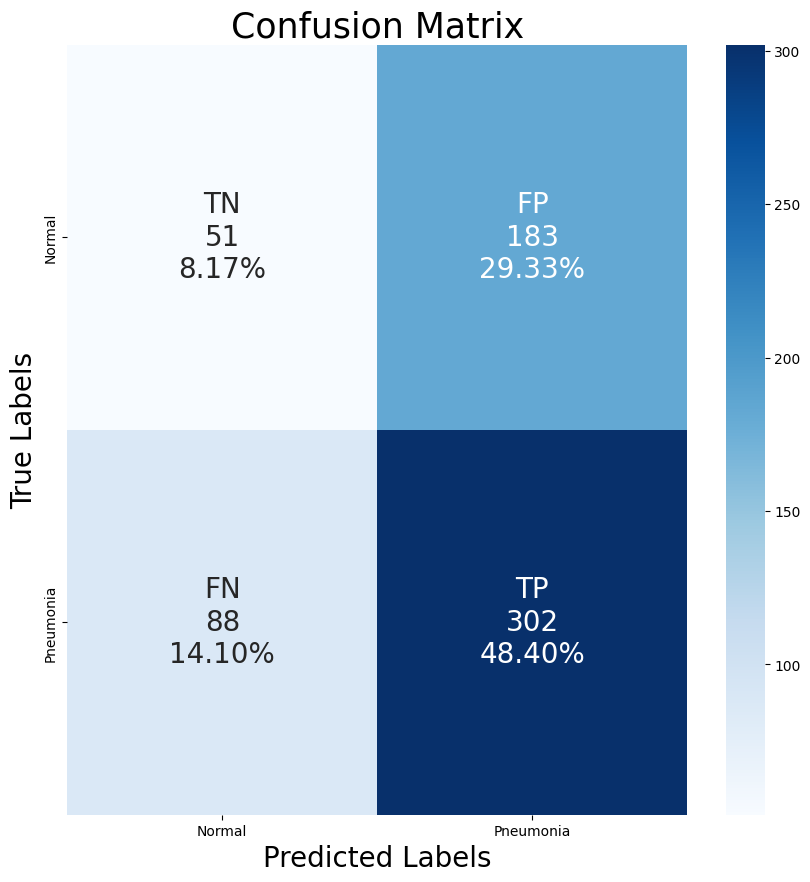

In [14]:
y_pred = model.predict(test_generator).argmax(axis=-1)

conf_mat = confusion_matrix(test_generator.classes, y_pred)


group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)

In [15]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  97.75 %
Validation Accuracy:  97.41 %
Test Accuracy:  81.25 %


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

# Load the model from file
model = tf.keras.models.load_model('/content/drive/MyDrive/Pneumonia/inceptionv3/my_model.h5')

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Pneumonia/inceptionv3/dataset/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg'
# image_path = '/content/drive/MyDrive/Pneumonia/inceptionv3/dataset/chest_xray/test/NORMAL/IM-0007-0001.jpeg'
img = image.load_img(image_path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions
predictions = model.predict(x)
print(predictions[0, 1]*100, " %")

# Print the top predictions
# decoded_predictions = decode_predictions(predictions)[0] # (predictions, top=3)[0]
# for pred in decoded_predictions:
#     print(f'{pred[1]}: {pred[2]*100:.2f}%')

1/1 [==============================] - 3s 3s/step
99.92949962615967  %


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = len(validation_generator)
y_true = validation_generator.classes
y_pred = model.predict(validation_generator).round().flatten()

# Calculate metrics
# classification_report = classification_report(y_true, y_pred)
confusion_mat = confusion_matrix(y_true, y_pred)
precision = confusion_mat[1][1] / (confusion_mat[1][1] + confusion_mat[0][1])
recall = confusion_mat[1][1] / (confusion_mat[1][1] + confusion_mat[1][0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


33/33 [==============================] - 35s 1s/step


ValueError: ignored